In [1]:
#import os
import sys
sys.path.append("../python/")
from helpers import *
#import pickle
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from scipy.special import softmax

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as tkr
from itertools import combinations
from scipy.stats import ttest_ind, f_oneway # for independent t-test

import math

from collections import Counter
import statistics as stat
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

In [2]:
# Globals
NUM_CHANNELS = 3
RESOLUTION_LIST = [336] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["PrPo_Im"] #, "Pr_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
AUGMENTATION = 'fliplr'
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'
FULL_MODEL_PATH = '../../results/models/opt-cnn-base-PrPo_Im-w-336-px-h-336-px/model'

In [3]:
trial_seed = 1
class_labels = getClassLabels("PrPo_Im")

In [4]:
GLOBAL_MODEL = models.load_model(FULL_MODEL_PATH)

In [5]:
IMAGE_SETS_SQUARE_TRAIN = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST, augmentation=AUGMENTATION, type='train', rectangular = False)
IMAGE_SETS_SQUARE_TEST = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST, augmentation=AUGMENTATION, type='test', rectangular = False)
IMAGE_SETS_SQUARE_VALIDATION = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST, augmentation=AUGMENTATION, type='validation', rectangular = False)

{336: {'PrPo_Im': array([[array([[[0.40392157, 0.50980392, 0.32156863],
                [0.4745098 , 0.57647059, 0.33333333],
                [0.56078431, 0.6627451 , 0.35686275],
                ...,
                [0.20784314, 0.27843137, 0.18431373],
                [0.13333333, 0.19607843, 0.14509804],
                [0.1254902 , 0.18823529, 0.1372549 ]],

               [[0.39215686, 0.50980392, 0.29411765],
                [0.52156863, 0.64313725, 0.32941176],
                [0.41568627, 0.53333333, 0.2745098 ],
                ...,
                [0.17647059, 0.23921569, 0.17254902],
                [0.12941176, 0.19607843, 0.14901961],
                [0.11372549, 0.17647059, 0.1372549 ]],

               [[0.25098039, 0.36470588, 0.29411765],
                [0.31372549, 0.41960784, 0.30196078],
                [0.35686275, 0.47058824, 0.31764706],
                ...,
                [0.11372549, 0.16862745, 0.12941176],
                [0.11372549, 0.17647059, 0.12941176

In [6]:
training_images, training_labels = getImageAndLabelArrays(IMAGE_SETS_SQUARE_TRAIN[336]["PrPo_Im"])
test_images, test_labels = getImageAndLabelArrays(IMAGE_SETS_SQUARE_TEST[336]["PrPo_Im"])
validation_images, validation_labels = getImageAndLabelArrays(IMAGE_SETS_SQUARE_VALIDATION[336]["PrPo_Im"])

In [7]:
training_images = np.concatenate((training_images,validation_images))
training_labels = np.concatenate((training_labels,validation_labels))

In [8]:
m = GLOBAL_MODEL

In [9]:
def grad_cam(index): 
    #assert validation_labels[index].mean(axis=0)[0] == 0 ## This will throw an error for an image in the 1 class. Elaborate on it or comment out.
    cam_img = index # class activation map corresponds to the specified image index 
    probPrediction = [] # store probability of prediction by the CNN
    predictedClass = [] # store CNN-predicted class 
    # class_labels = getClassLabels("PrPo_Im")
    print("Observed image class: ", class_labels[np.argmax(test_labels[cam_img])])
    m = GLOBAL_MODEL
    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print("Loss output: ", output) ##
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in test_labels[cam_img] ])]
        print(loss_list)
        probPrediction.append(str([np.round(max(softmax(loss)), 2) for loss in output.numpy()])[1:-1])
        predictedClass.append(class_labels[np.argmax([softmax(loss) for loss in output.numpy()])])
        print('Probability of prediction: ', probPrediction)
        print('Predicted class: ', predictedClass)
        print([softmax(loss) for loss in output.numpy()])
        return loss_list

    # print('Class labels: ', class_labels)
    
    # Model_modifier function required for gradcam
    def model_modifier(model):
        """Remove softmax activation of last layer in model"""
        model.layers[-1].activation = tf.keras.activations.linear # Assign linear activation function (pass-through) to the activation of layer at -1
        return model
    
    gradcam_image = np.squeeze(test_images[cam_img])
    gradcam = Gradcam(m, model_modifier = model_modifier)
    cam = gradcam(loss, gradcam_image, penultimate_layer = -1) # Penultimate layer is a fully-connected hidden layer. 
    cam = normalize(cam)
    cam = np.squeeze(cam) # replace np.squeeze 
    print(gradcam_image.shape)
    print("Shape of heatmap matrix:", cam.shape )
    return cam, gradcam_image, probPrediction, predictedClass

In [10]:
def renderGradCam(index, save=False, grid=False, c_map='gist_gray'):
    '''Visualizing gradient-weighted class activation maps as an overlay (heatmap) to the original image.'''
    gradcam_dir = '../../figures/plottingGradCam/6_27_2022/'
    gcam = grad_cam([index])
    # class_labels = getClassLabels("PrPo_Im")
    save_name = ""
    if grid==False:
        plt.figure(figsize=(5, 5))
        # plt.suptitle('Grad-CAM Index '+str(index)[1:-1]+'\n')
        # plt.title('Observed class: '+class_labels[np.argmax(test_labels[index])], y=-0.08)
        # plt.text(-0.7,-0.05, "Probability of prediction: "+ str("{:.0%}".format(float(str(gcam[2])[2:-2])))+'\n', size=12)
        # plt.text(-0.7,-0.35, 'Predicted class: '+ str(gcam[3])[2:-2], size=12)
        plt.axis('off')
        plt.tight_layout()
        heatmap = np.uint8(cm.jet(gcam[0])[..., :3] * 255)
        plt.imshow(np.squeeze(gcam[1]), cmap=c_map) # remove axes of length one from gradcam_images
        plt.imshow(heatmap, cmap='gist_gray', alpha=0.5) # overlay
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
    else:
        plt.axis('off')
        plt.tight_layout()
        heatmap = np.uint8(cm.jet(gcam[0])[..., :3] * 255)
        plt.imshow(np.squeeze(gcam[1]), cmap=c_map)
        plt.imshow(heatmap, cmap='gist_gray', alpha=0.5)
    # print(gradcam_dir+"gradcam-"+str(index)[1:-1])
    predicted_class = str(gcam[3])[2:-2]
    observed_class = class_labels[np.argmax(test_labels[index])]
    if predicted_class == "Probable/Possible" and predicted_class == observed_class:
        save_name = "tp"
    elif predicted_class == "Probable/Possible" and predicted_class != observed_class:
        save_name = "fp"
    elif predicted_class == "Improbable" and predicted_class == observed_class:
        save_name = "tn"
    elif predicted_class == "Improbable" and predicted_class != observed_class:
        save_name = "fn"
    print(save_name)
    if save:
        if not os.path.exists(gradcam_dir):
            os.makedirs(gradcam_dir)
        plt.savefig(gradcam_dir+"index_"+str(index)+"_"+save_name+"_"+str("{:.2f}".format(float(str(gcam[2])[2:-2])))+".png")
    print(str(gcam[3])[2:-2])
    return (heatmap)

In [11]:
def get_summary_statistics(data):
    data = [float(x) for x in data]
    mean = np.round(stat.mean(data), 2)
    median = np.round(stat.median(data), 2)
    std = np.round(stat.stdev(data), 2)
    min_value = np.round(min(data), 2)
    max_value = np.round(max(data), 2)
    # quartile_1 = np.round(data.quantile(0.25), 2)
    # quartile_3 = np.round(data.quantile(0.75), 2)
    # # Interquartile range
    # iqr = np.round(quartile_3 - quartile_1, 2)
    print('Min: %s' % min_value)
    print('Mean: %s' % mean)
    print('Max: %s' % max_value)
    # print('25th percentile: %s' % quartile_1)
    print('Median: %s' % median)
    print('Standard deviation: %s' % std)
    # print('75th percentile: %s' % quartile_3)
    # print('Interquartile range (IQR): %s' % iqr)
#     print('Setosa summary statistics')
# print('\n\nSetosa summary statistics')
# get_summary_statistics(setosa_petal_length)
# print('\n\nVersicolor summary statistics')
# get_summary_statistics(versicolor_petal_length)
# print('\n\nVirginica summary statistics')
# get_summary_statistics(virginica_petal_length)

In [12]:
def analyzePredictions(labels):
    """Returns the indices of the test images for both correct and incorrect predictions. 
    The total number for each class should equal the corresponding value in the confusion matrix.
    Currently only scenario PrPo_Im is supported."""
    im = labels[0]
    prPo = labels[1]
    prediction_probabilities = {im+'_correct': [],
                   im+'_incorrect': [],
                   prPo+'_correct':[],
                   prPo+'_incorrect':[]}
    prediction_indices = {im+'_correct': [],
                   im+'_incorrect': [],
                   prPo+'_correct':[],
                   prPo+'_incorrect':[]}
    for i in range(len(test_labels)):
        observed = class_labels[np.argmax(test_labels[i])]
        predicted = str(grad_cam([i])[3])[2:-2]
        pred_prob = grad_cam([i])[2][0]
        if observed == im:
            if predicted == observed:
                prediction_indices[im+'_correct'].append(i)
                prediction_probabilities[im+'_correct'].append(pred_prob)
            else:
                prediction_indices[im+'_incorrect'].append(i)
                prediction_probabilities[im+'_incorrect'].append(pred_prob)
        else:
            if predicted == observed:
                prediction_indices[prPo+'_correct'].append(i)
                prediction_probabilities[prPo+'_correct'].append(pred_prob)
            else:
                prediction_indices[prPo+'_incorrect'].append(i)
                prediction_probabilities[prPo+'_incorrect'].append(pred_prob)
    return prediction_indices, prediction_probabilities

In [13]:
def getRates(predictions, to_float_sorted=True):
    tp_ind  = predictions[0][class_labels[1]+'_correct']
    tn_ind  = predictions[0][class_labels[0]+'_correct']
    fp_ind  = predictions[0][class_labels[1]+'_incorrect']
    fn_ind  = predictions[0][class_labels[0]+'_incorrect']
    tp_prob  = predictions[1][class_labels[1]+'_correct']
    tn_prob  = predictions[1][class_labels[0]+'_correct']
    fp_prob  = predictions[1][class_labels[1]+'_incorrect']
    fn_prob  = predictions[1][class_labels[0]+'_incorrect']
    if to_float_sorted:
        tp_prob = sorted([float(x) for x in tp_prob])
        tn_prob = sorted([float(x) for x in tn_prob])
        fp_prob = sorted([float(x) for x in fp_prob])
        fn_prob = sorted([float(x) for x in fn_prob])
    return (tp_ind, tp_prob),(tn_ind, tn_prob),(fp_ind, fp_prob),(fn_ind, fn_prob)

In [14]:
pred_prob = analyzePredictions(class_labels)

Observed image class:  Improbable
Loss output:  tf.Tensor([[0.01768339 0.00989442]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.017683389>]
Probability of prediction:  ['0.5']
Predicted class:  ['Improbable']
[array([0.5019473, 0.4980528], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Observed image class:  Improbable
Loss output:  tf.Tensor([[0.01768339 0.00989442]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.017683389>]
Probability of prediction:  ['0.5']
Predicted class:  ['Improbable']
[array([0.5019473, 0.4980528], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Observed image class:  Improbable
Loss output:  tf.Tensor([[ 0.23064122 -0.12931599]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.23064122>]
Probability of prediction:  ['0.59']
Predicted class:  ['Improbable']
[array([0.5890301 , 0.41096988], dtype=float32)]
(336, 336, 3)
Shape of heatmap m

In [15]:
tp,fp,tn,fn = getRates(pred_prob)
rates = {"True Positive":tp,
         "False Positive":fp,
         "True Negative":tn,
         "False Negative":fn}

In [153]:
gcam_ind = {"tp":[3,10, 20,30],
                "fp":[1,10,15,20],
                "tn":[2,4,6,8],
                "fn":[1,10,15,20]}

Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[-0.07856157  0.06950021]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.06950021>]
Probability of prediction:  ['0.54']
Predicted class:  ['Probable/Possible']
[array([0.463052  , 0.53694797], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
tp
Probable/Possible
Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[-0.13734743  0.21623743]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.21623743>]
Probability of prediction:  ['0.59']
Predicted class:  ['Probable/Possible']
[array([0.4125134, 0.5874867], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
tp
Probable/Possible
Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[-0.1595484   0.30991873]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.30991873>]
Probability of prediction:  ['0.62']
Predicted class:  ['Probable/Po

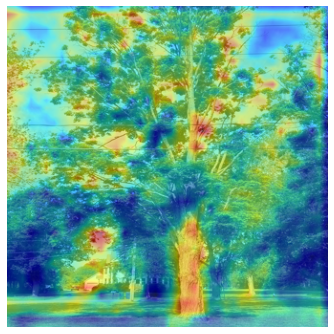

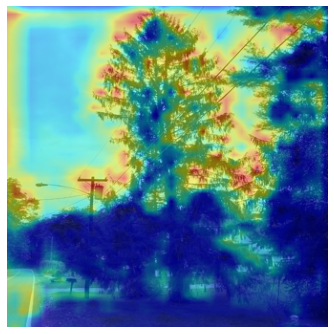

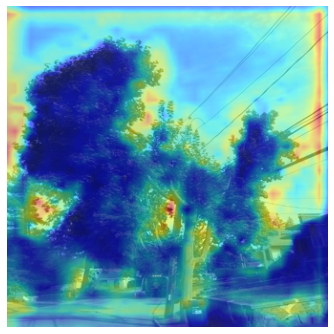

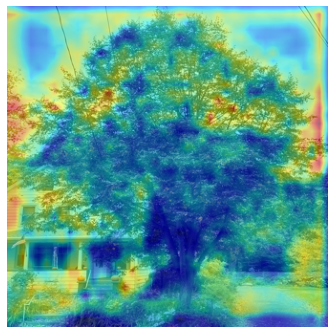

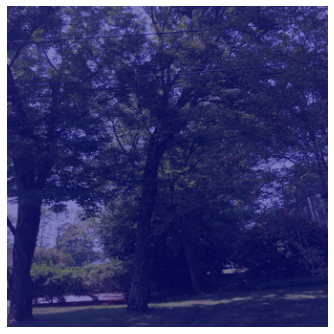

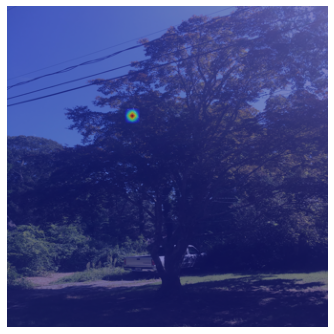

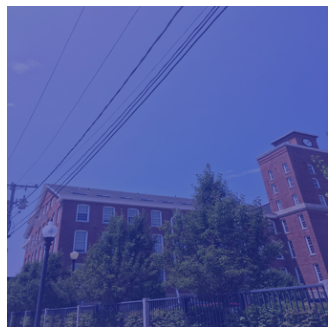

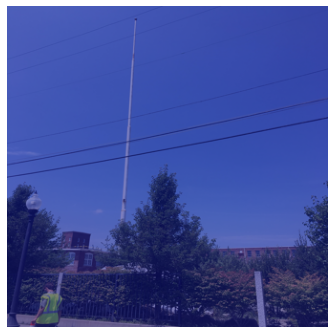

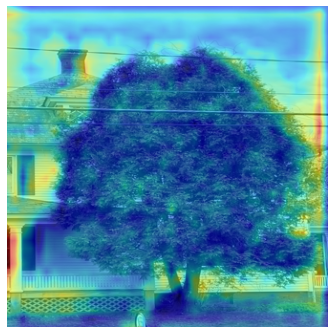

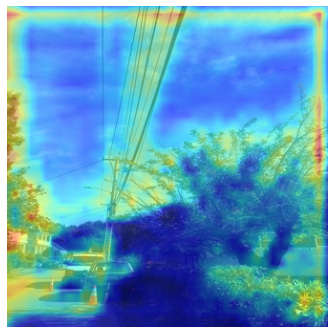

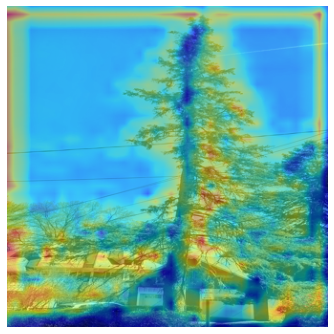

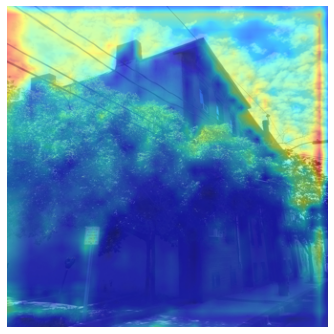

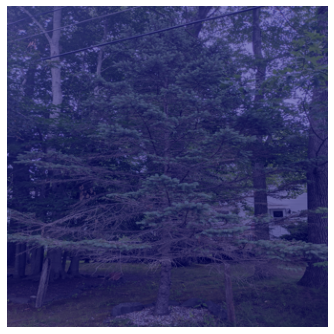

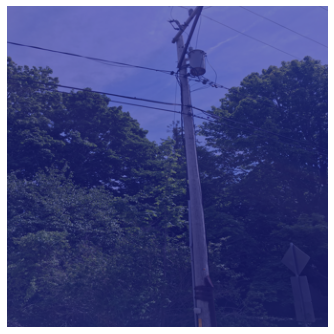

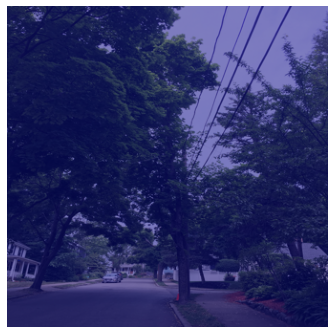

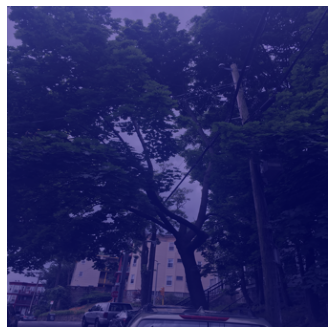

In [170]:
for k,v in gcam_ind.items():
    if k == "tp":
        for i in v:
            renderGradCam(rates["True Positive"][0][i], save=True)
    elif k == "fp":
        for i in v:
            renderGradCam(rates["False Positive"][0][i], save=True)
    elif k == "tn":
        for i in v:
            renderGradCam(rates["True Negative"][0][i], save=True)
    else:
        for i in v:
            renderGradCam(rates["False Negative"][0][i], save=True)

## Print summary statistics for the predictions

In [16]:
for k,v in rates.items():
    print(k)
    get_summary_statistics(v[1])
    print("\n")

True Positive
Min: 0.52
Mean: 0.64
Max: 0.86
Median: 0.64
Standard deviation: 0.09


False Positive
Min: 0.5
Mean: 0.7
Max: 0.91
Median: 0.72
Standard deviation: 0.11


True Negative
Min: 0.51
Mean: 0.66
Max: 0.91
Median: 0.65
Standard deviation: 0.1


False Negative
Min: 0.51
Mean: 0.6
Max: 0.79
Median: 0.59
Standard deviation: 0.06




In [133]:
test_dict = {"tp":[],
            "fp":[],
            "tn":[],
            "fn":[]}
test_dict["tp"].append(1)
test_dict["tp"].append(2)
print(len(test_dict["tp"]))

2


In [142]:
def renderCustomGCAM(): #rate,desired_probability
    tp,fp,tn,fn = getRates(pred_prob)
    rates = {"True Positive":tp,
             "False Positive":fp,
             "True Negative":tn,
             "False Negative":fn}
    interv = round(0.5/4,4)
    gcam_ind = {"tp":[],
                "fp":[],
                "tn":[],
                "fn":[]}
    qt = []
    for i in np.arange(0.5,1,interv):
        qt.append(round(i,3))
    for k,v in rates.items():
        if k == "True Positive":
            tp_probs = []
            for prob in v[1]:
                if len(tp_probs) < 4:
                    for j in range(len(qt)):
                        if prob > j and j not in tp_probs:
                            gcam_ind["tp"].append(v[0][prob])
                            tp_probs.append(j)
    print(gcam_ind)

In [114]:
interv = round(0.5/4,4)
qt = []
for i in np.arange(0.5,1,interv):
    qt.append(round(i,3))

In [115]:
for i in range(len(qt)):
    print(qt[i])

0.5
0.625
0.75
0.875


Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[-0.30444628  0.43828037]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.43828037>]
Probability of prediction:  ['0.68']
Predicted class:  ['Probable/Possible']
[array([0.32240823, 0.67759186], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Probable/Possible


array([[[ 79, 255, 166],
        [ 70, 255, 176],
        [ 57, 255, 189],
        ...,
        [  0, 144, 255],
        [  0, 132, 255],
        [  0, 124, 255]],

       [[112, 255, 134],
        [102, 255, 144],
        [ 92, 255, 154],
        ...,
        [  0, 160, 255],
        [  0, 144, 255],
        [  0, 128, 255]],

       [[144, 255, 102],
        [134, 255, 112],
        [124, 255, 121],
        ...,
        [  0, 176, 255],
        [  0, 156, 255],
        [  0, 132, 255]],

       ...,

       [[108, 255, 137],
        [ 92, 255, 154],
        [ 76, 255, 170],
        ...,
        [  0,  48, 255],
        [  0,  28, 255],
        [  0,   4, 255]],

       [[108, 255, 137],
        [ 92, 255, 154],
        [ 76, 255, 170],
        ...,
        [  0,  48, 255],
        [  0,  28, 255],
        [  0,   8, 255]],

       [[105, 255, 141],
        [ 92, 255, 154],
        [ 76, 255, 170],
        ...,
        [  0,  44, 255],
        [  0,  24, 255],
        [  0,   8, 255]]

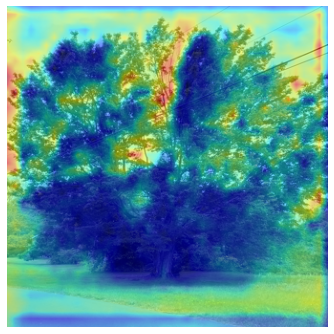

In [92]:
renderGradCam(rates["True Positive"][0][i], save=True)

In [17]:
rates["True Positive"][1]

[0.52,
 0.52,
 0.54,
 0.54,
 0.55,
 0.56,
 0.56,
 0.56,
 0.56,
 0.57,
 0.57,
 0.58,
 0.59,
 0.61,
 0.63,
 0.64,
 0.64,
 0.64,
 0.65,
 0.65,
 0.66,
 0.66,
 0.68,
 0.69,
 0.69,
 0.7,
 0.71,
 0.72,
 0.76,
 0.81,
 0.82,
 0.84,
 0.86]

Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[-0.13540056  0.13504001]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.13504001>]
Probability of prediction:  ['0.57']
Predicted class:  ['Probable/Possible']
[array([0.43279895, 0.5672011 ], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Probable/Possible
Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[-0.19427055  0.34940967]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.34940967>]
Probability of prediction:  ['0.63']
Predicted class:  ['Probable/Possible']
[array([0.3673319 , 0.63266814], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
Probable/Possible
Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[-0.06413617 -0.01878192]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=-0.01878192>]
Probability of prediction:  ['0.51']
Predicted class:  ['Probable/Possi

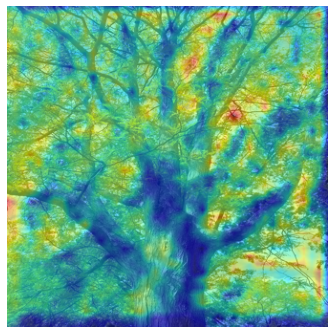

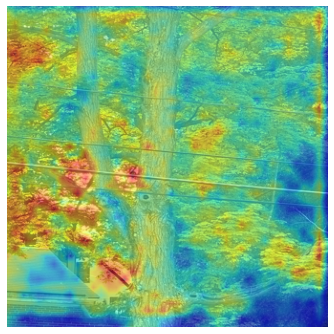

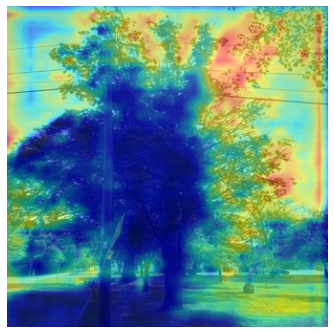

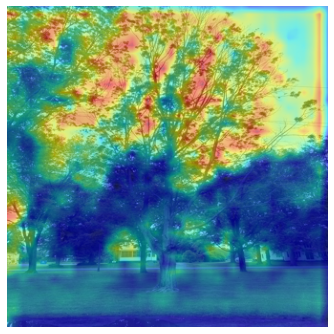

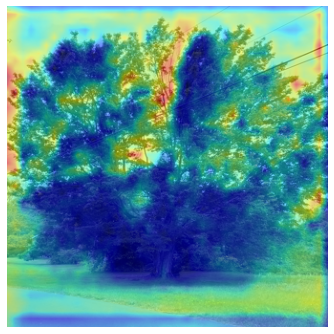

In [87]:
for i in range(0,10,2):
    renderGradCam(rates["True Positive"][0][i])

Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[0.00552381 0.05568361]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.05568361>]
Probability of prediction:  ['0.51']
Predicted class:  ['Probable/Possible']
[array([0.48746267, 0.5125373 ], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)


array([[[  0,  88, 255],
        [  0,  80, 255],
        [  0,  72, 255],
        ...,
        [ 70, 255, 176],
        [ 63, 255, 183],
        [ 57, 255, 189]],

       [[  0,  72, 255],
        [  0,  64, 255],
        [  0,  60, 255],
        ...,
        [ 70, 255, 176],
        [ 60, 255, 186],
        [ 50, 255, 195]],

       [[  0,  52, 255],
        [  0,  52, 255],
        [  0,  48, 255],
        ...,
        [ 66, 255, 179],
        [ 57, 255, 189],
        [ 47, 255, 199]],

       ...,

       [[  0,  24, 255],
        [  0,  36, 255],
        [  0,  48, 255],
        ...,
        [  0,   0, 191],
        [  0,   0, 177],
        [  0,   0, 159]],

       [[  0,  28, 255],
        [  0,  36, 255],
        [  0,  44, 255],
        ...,
        [  0,   0, 172],
        [  0,   0, 159],
        [  0,   0, 141]],

       [[  0,  32, 255],
        [  0,  36, 255],
        [  0,  44, 255],
        ...,
        [  0,   0, 150],
        [  0,   0, 136],
        [  0,   0, 127]]

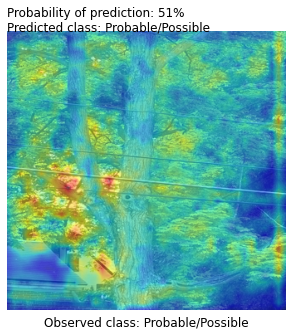

In [272]:
renderGradCam(tp[0][2])

In [18]:
def plotPredictionProbabilities(save_fig=False):
    """Generate summary statistics for True Positive, True Negative, False Positive
    and False Negative Rates"""
    tp,fp,tn,fn = getRates(pred_prob)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    # Remove top and right border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Remove y-axis tick marks
    ax.yaxis.set_ticks_position('none')
    # Add major gridlines in the y-axis
    ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
    # Set plot title
    # ax.set_title('Distribution of prediction probabilitiees', fontsize=24)
    data = [tp[1], fp[1], tn[1], fn[1]]
    lbls = [['TP'],['FP'],['TN'],['FN']]
    bp1 = ax.boxplot(data[0], positions=[0], notch=False, widths=0.35, 
                    patch_artist=True, boxprops=dict(facecolor="#E31A1C"), labels=lbls[0]) #
    # plt.xlabel(lbls[0],fontsize=18)
    bp2 = ax.boxplot(data[1], positions=[1], notch=False, widths=0.35, # median to black
                    patch_artist=True, boxprops=dict(facecolor="#FB9A99"), labels=lbls[1])
    bp3 = ax.boxplot(data[2], positions=[2], notch=False, widths=0.35, 
                    patch_artist=True, boxprops=dict(facecolor="#33A02C"), labels=lbls[2])
    bp4 = ax.boxplot(data[3], positions=[3], notch=False, widths=0.35, 
                    patch_artist=True, boxprops=dict(facecolor="#B2DF8A"), labels=lbls[3])
    # ax.set_ylabel('Prediction Probabilities', fontsize=18)
    ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]], 
              ['True Positive (TP)','False Positive (FP)','True Negative (TN)','False Negative (FN)'], 
              bbox_to_anchor=(1,0.5), loc='center left', prop={'size': 18})
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(which='major', axis='y', linestyle='-', linewidth=0.25, alpha=0.5, zorder=-1.0)
    fig.tight_layout()
    if save_fig:
        plt.savefig('../../figures/summary_statistics_tp_tn_fp_fn.jpg', dpi=180)
    plt.show()

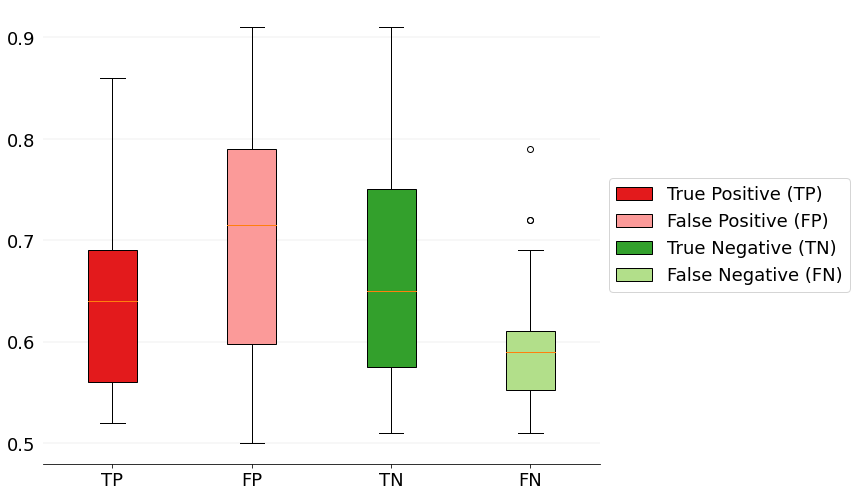

In [19]:
plotPredictionProbabilities()

In [20]:
def plotProbabilities(outcome, n_bins=10, font_size=22, save_fig=False):
    tp,fp,tn,fn = getRates(pred_prob)
    # plt.grid(True)
    plt.figure(figsize=(15,7)).gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    t = ''
    # plt.grid(which='major', axis='y', zorder=-1.0)
    
    if outcome == 'tp':
        t = 'true_positive'
        plt.hist(tp[1], color="#E31A1C", bins=n_bins)
    elif outcome == 'tn':
        t = 'true_negative'
        plt.hist(tn[1], color="#33A02C", bins=n_bins)
    elif outcome == 'fp':
        t = 'false_positive'
        plt.hist(fp[1], color="#FB9A99", bins=n_bins)

    elif outcome == 'fn':
        t = 'false_negative'
        plt.hist(fn[1], color="#B2DF8A", bins=n_bins)
    plt.xlabel('Probabilities', fontsize=font_size)
    plt.ylabel('Counts', fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    # plt.title(t, fontsize=24)
    plt.grid(which='major', axis='y', zorder=-1.0)
    plt.tight_layout()
    # plt.title('Prediction probabilities for '+t+' Probable/Possible images')
    if save_fig:
        plt.savefig('../../figures/prpo_'+t+'_predictions_dist.jpg', dpi=180)

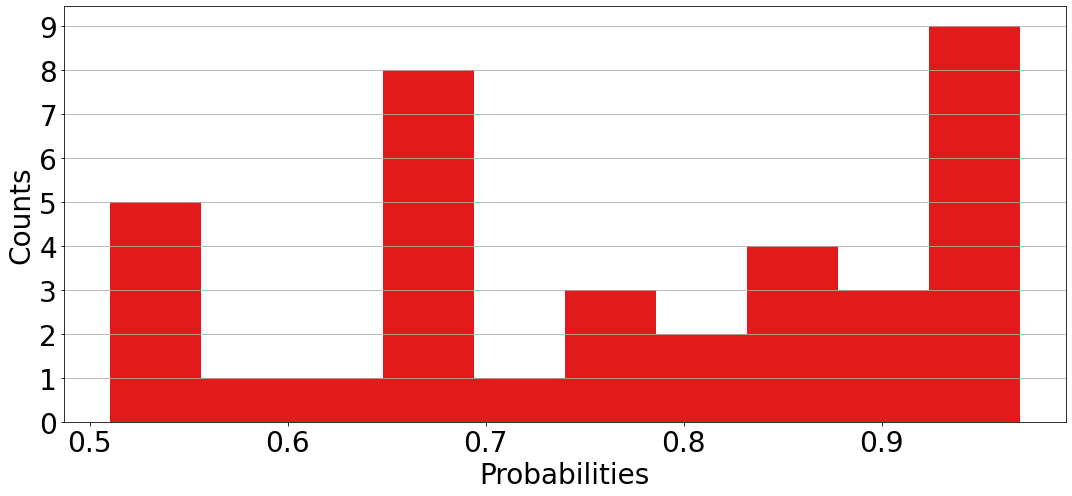

In [47]:
plotProbabilities('tp', font_size=28)

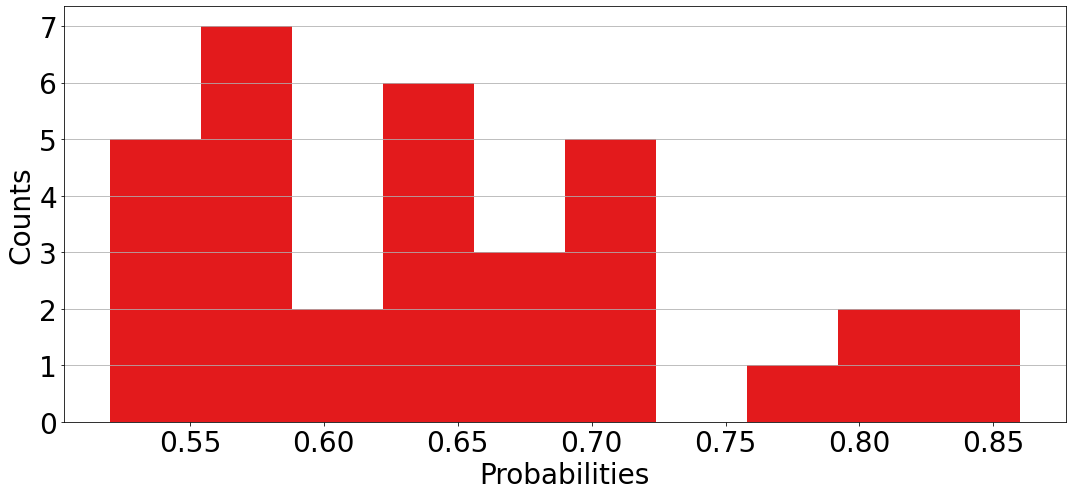

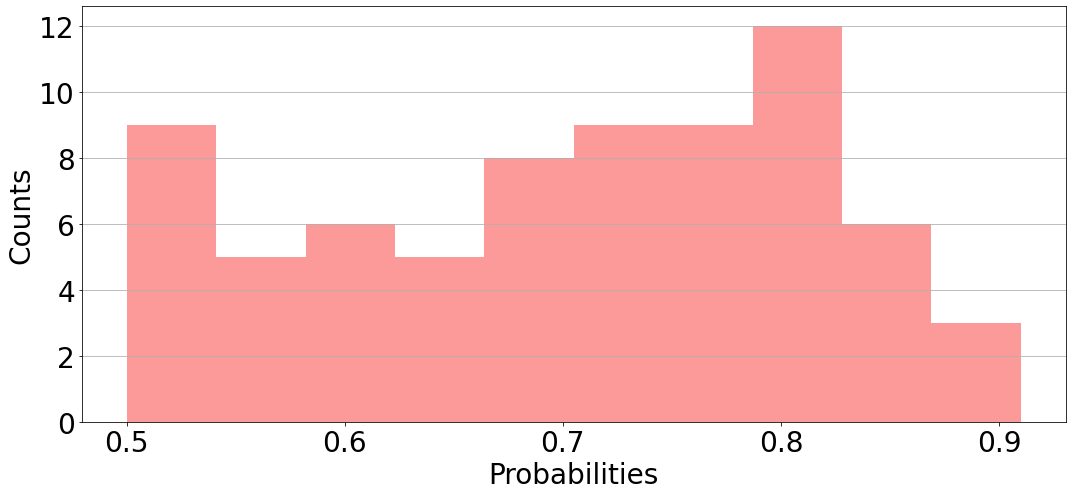

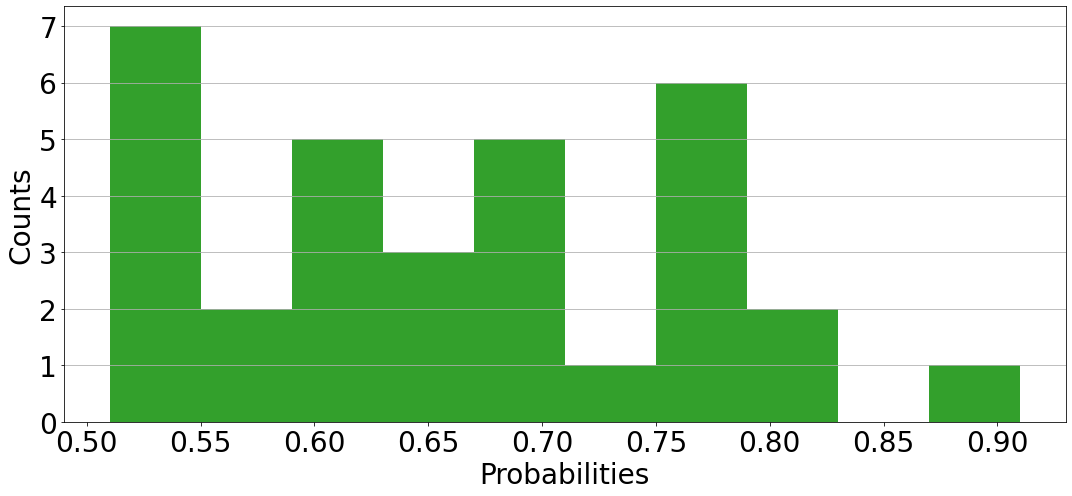

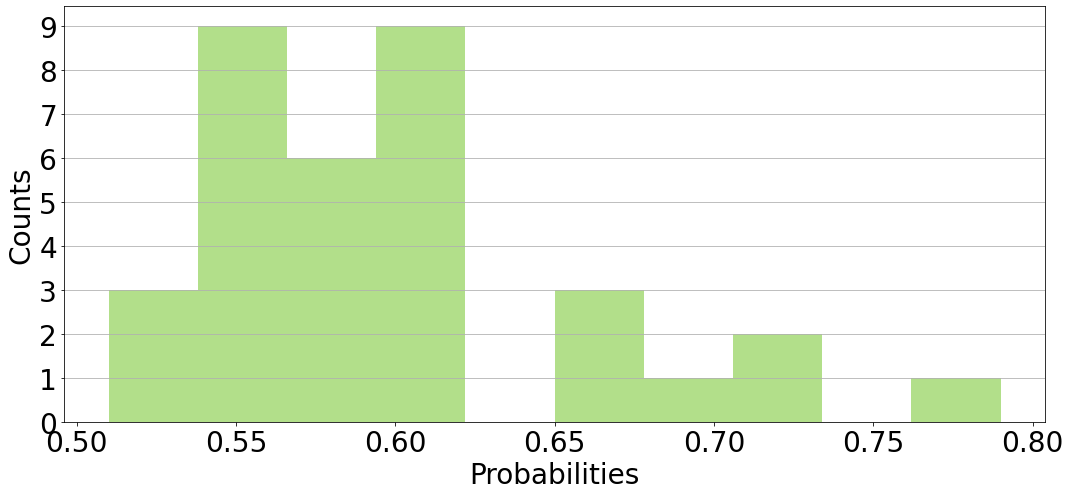

In [21]:
for o in ['tp','fp','tn','fn']:
    plotProbabilities(o, font_size=28)

Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[-0.34770903  0.4402128 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.4402128>]
Probability of prediction:  ['0.69']
Predicted class:  ['Probable/Possible']
[array([0.31261507, 0.68738496], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)
tp
Probable/Possible


array([[[  0,   0, 150],
        [  0,   0, 195],
        [  0,   0, 245],
        ...,
        [ 76, 255, 170],
        [137, 255, 108],
        [195, 255,  50]],

       [[  0,   0, 154],
        [  0,   0, 195],
        [  0,   0, 236],
        ...,
        [ 70, 255, 176],
        [128, 255, 118],
        [186, 255,  60]],

       [[  0,   0, 159],
        [  0,   0, 191],
        [  0,   0, 227],
        ...,
        [ 63, 255, 183],
        [118, 255, 128],
        [173, 255,  73]],

       ...,

       [[  0,   0, 177],
        [  0,   0, 186],
        [  0,   0, 195],
        ...,
        [  0,  32, 255],
        [  0,  32, 255],
        [  0,  28, 255]],

       [[  0,   0, 177],
        [  0,   0, 182],
        [  0,   0, 191],
        ...,
        [  0,   8, 255],
        [  0,   4, 255],
        [  0,   4, 255]],

       [[  0,   0, 177],
        [  0,   0, 182],
        [  0,   0, 186],
        ...,
        [  0,   0, 255],
        [  0,   0, 250],
        [  0,   0, 245]]

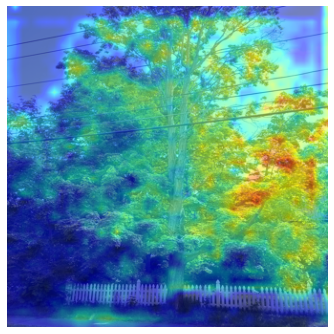

In [22]:
renderGradCam(tp[0][0])

In [ ]:
def plotVisualizations(index, activation_layer='conv2d_4', c_map='gist_gray', save=False):
    subplot_args = { 'nrows': 4, 'ncols': 4, 'figsize': (15, 15), 
                    'subplot_kw': {'xticks': [], 'yticks': []} }
    grid_dir = '../../figures/'
    plot_name = 'plot_grid_'+str(index)
    f, axs = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    axis_labels = ['Processed Input', 'GradCAM', 'Guided Backprop', 'Guided GradCAM']
    orig_image = validation_images[index]
    gcam_heatmap = renderGradCam(index, False, True)    
    gbp = renderGBP(index, activation_layer, False, True)
    ggcam = renderGGCAM(index, activation_layer, False, True)
    f.suptitle('Observed: ' + class_labels[np.argmax(validation_labels[index])]+ '. Predicted: ' + str(grad_cam([index])[3])[2:-2]+'. Probability: '+str("{:.0%}".format(float(str(grad_cam([index])[2])[2:-2])))+'.', y=0.595, fontsize=24, va='bottom') 
    axs[0].imshow(np.squeeze(orig_image))
    axs[1].imshow(np.squeeze(orig_image))
    axs[1].imshow(gcam_heatmap, cmap=c_map, alpha=0.5)
    axs[2].imshow(gbp, cmap=c_map)
    axs[3].imshow(ggcam, cmap=c_map)
    for axis in f.axes:
        axis.set_axis_on()
        axis.set_xticks([])
        axis.set_yticks([])
        axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)
        axis.spines["left"].set_visible(False)
        axis.spines["bottom"].set_visible(False)        
    for i, axis in enumerate(f.axes):
        axis.set_xlabel(axis_labels[i], fontsize=18)
    f.tight_layout(rect=[0, 0, 1, 0.95])
    if save:
        f.savefig(grid_dir+plot_name, bbox_inches='tight')
        print('Saving '+plot_name+' in '+grid_dir)
    return 

In [41]:
for r in rates:
    get_summary_statistics(r)
    print('\n')

Min: 0.52
Mean: 0.87
Max: 1.0
Median: 0.92
Standard deviation: 0.13


Min: 0.52
Mean: 0.82
Max: 0.99
Median: 0.85
Standard deviation: 0.13


Min: 0.5
Mean: 0.82
Max: 1.0
Median: 0.84
Standard deviation: 0.15


Min: 0.5
Mean: 0.85
Max: 1.0
Median: 0.89
Standard deviation: 0.13




In [276]:
len(fn[0])

47

In [45]:
for r in rates:
    print(Counter(r).most_common(),'\n')

[('0.98', 6), ('1.0', 5), ('0.99', 4), ('0.85', 3), ('0.84', 2), ('0.8', 2), ('0.94', 2), ('0.79', 2), ('0.91', 2), ('0.97', 1), ('0.9', 1), ('0.75', 1), ('0.63', 1), ('0.6', 1), ('0.76', 1), ('0.74', 1), ('0.92', 1), ('0.52', 1), ('0.93', 1), ('0.59', 1), ('0.83', 1), ('0.66', 1), ('0.95', 1)] 

[('0.94', 3), ('0.9', 2), ('0.85', 2), ('0.92', 1), ('0.52', 1), ('0.72', 1), ('0.87', 1), ('0.83', 1), ('0.97', 1), ('0.66', 1), ('0.99', 1), ('0.82', 1), ('0.73', 1), ('0.68', 1), ('0.95', 1), ('0.64', 1), ('0.96', 1), ('0.77', 1), ('0.62', 1)] 

[('0.99', 5), ('0.95', 4), ('1.0', 3), ('0.96', 3), ('0.97', 3), ('0.8', 3), ('0.91', 3), ('0.92', 3), ('0.79', 2), ('0.73', 2), ('0.62', 2), ('0.84', 2), ('0.56', 2), ('0.5', 2), ('0.9', 2), ('0.71', 1), ('0.54', 1), ('0.72', 1), ('0.58', 1), ('0.57', 1), ('0.83', 1), ('0.85', 1), ('0.78', 1), ('0.63', 1), ('0.81', 1), ('0.66', 1), ('0.77', 1), ('0.88', 1), ('0.51', 1), ('0.7', 1), ('0.68', 1), ('0.74', 1), ('0.89', 1)] 

[('0.97', 5), ('0.92', 4),

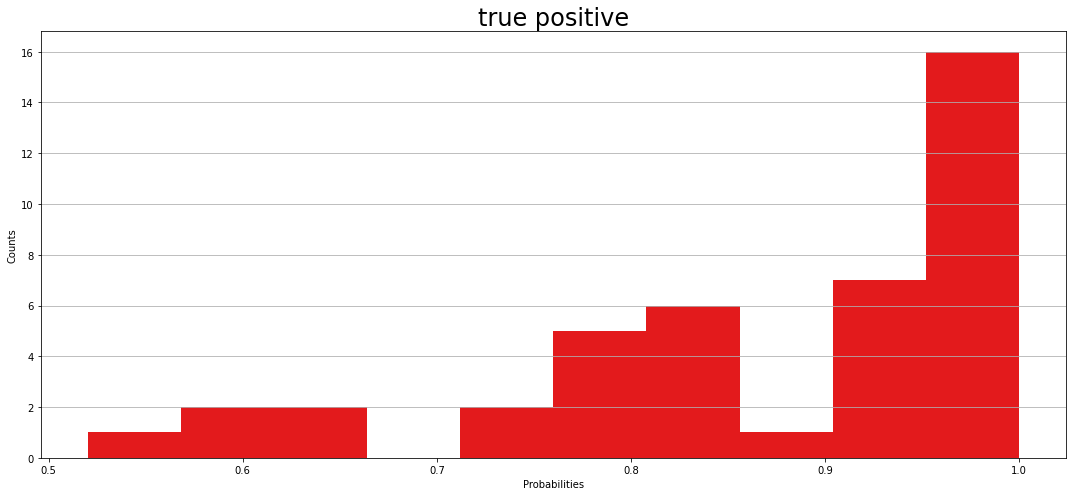

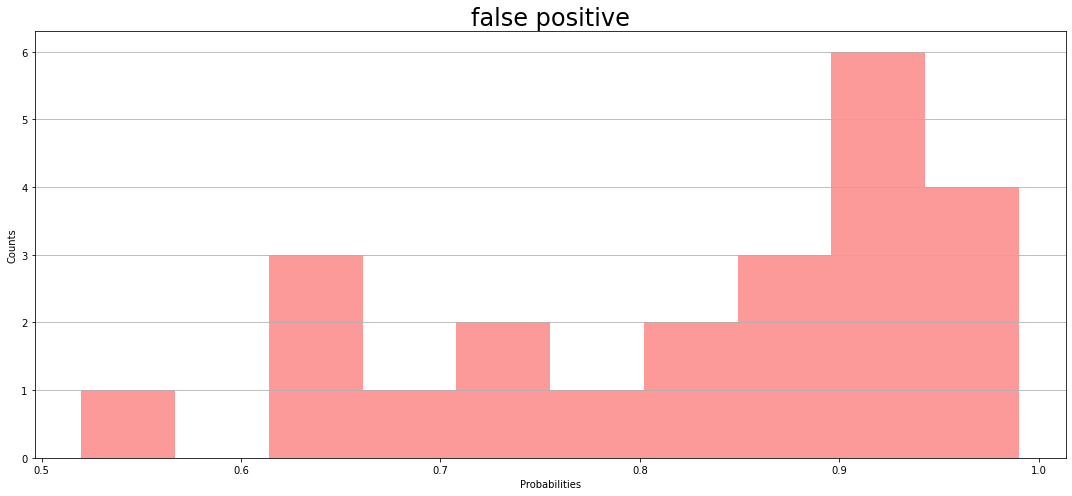

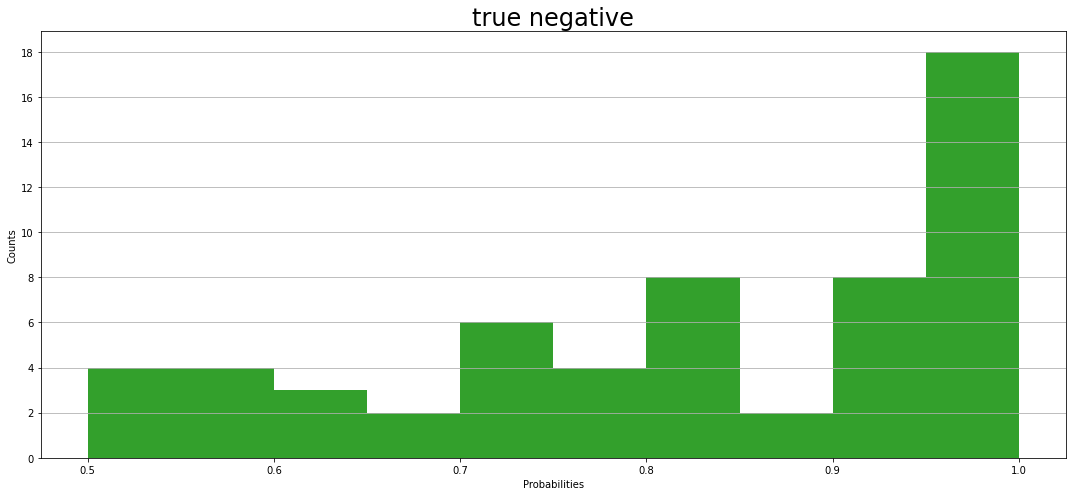

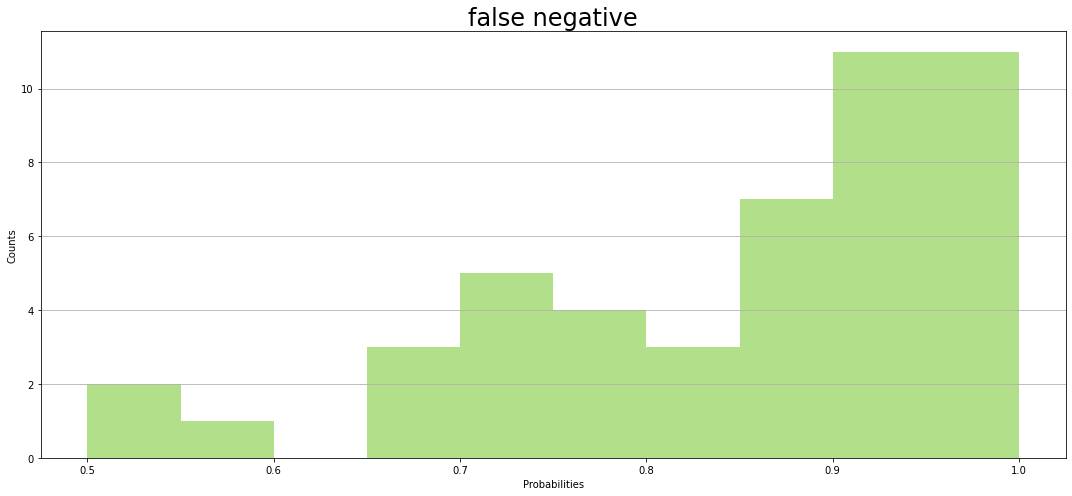

In [44]:
for l in ['tp','fp','tn','fn']:
    plotProbabilities(l, 10, True)

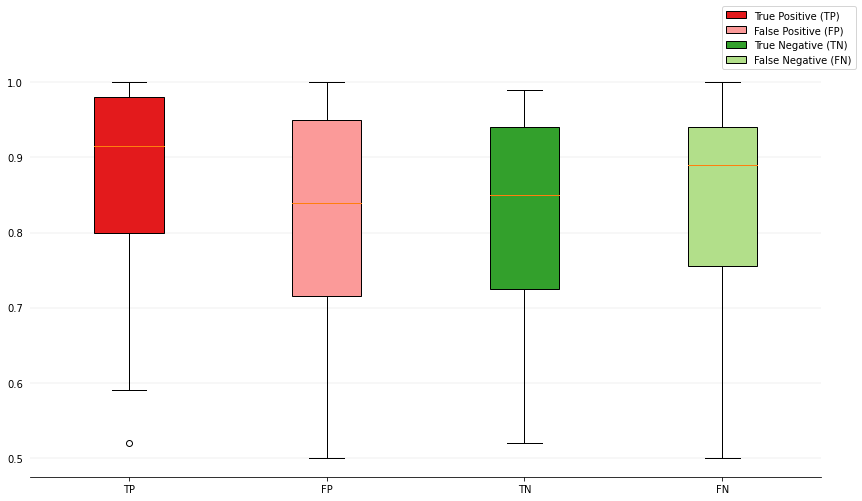

In [122]:
plotPredictionProbabilities()

In [26]:
tp1 = [float(x) for x in tp]
tn1 = [float(x) for x in tn]
fp1 = [float(x) for x in fp]
fn1 = [float(x) for x in fn]

In [29]:
tp1

[106.0,
 107.0,
 109.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 123.0,
 124.0,
 127.0,
 129.0,
 130.0,
 134.0,
 137.0,
 138.0,
 139.0,
 140.0,
 141.0,
 142.0,
 143.0,
 144.0,
 145.0,
 147.0,
 148.0,
 149.0,
 150.0,
 151.0,
 153.0,
 154.0,
 155.0,
 158.0,
 162.0,
 166.0,
 167.0,
 168.0,
 169.0,
 170.0]

In [19]:
grad_cam([tp1[10]])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [109]:
print(min([float(x) for x in tp]))

0.52


In [10]:
obj1 = grad_cam([10])

Observed image class:  Improbable
Loss output:  tf.Tensor([[-1.3862385  1.1933436]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=-1.3862385>]
Probability of prediction:  ['0.93']
Predicted class:  ['Probable/Possible']
[array([0.0704641 , 0.92953587], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)


In [39]:
grad_cam([10])[2][0]

Observed image class:  Improbable
Loss output:  tf.Tensor([[-0.01835316  0.01353806]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=-0.01835316>]
Probability of prediction:  ['0.51']
Predicted class:  ['Probable/Possible']
[array([0.49202788, 0.50797206], dtype=float32)]
(336, 336, 3)
Shape of heatmap matrix: (336, 336)


'0.51'

In [104]:
Counter(tp).most_common(1)[0][1]

19

In [13]:
# class_labels[0] -> improbable; class_labels[1] -> probable/possible
print("Total number of test images:", len(test_images),'\n')
print("Indices of correct", class_labels[1], "predictions:", pred_prob[class_labels[1]+'_correct'], 'Total:', len(pred_prob[class_labels[1]+'_correct']), '\n')
print("Indices of correct", class_labels[0], "predictions:", pred_prob[class_labels[0]+'_correct'], 'Total:', len(pred_prob[class_labels[0]+'_correct']),'\n')
print("Indices of incorrect", class_labels[1], "predictions:", pred_prob[class_labels[1]+'_incorrect'], 'Total:', len(pred_prob[class_labels[1]+'_incorrect']),'\n')
print("Indices of incorrect", class_labels[0], "predictions:", pred_prob[class_labels[0]+'_incorrect'], 'Total:', len(pred_prob[class_labels[0]+'_incorrect']),)

Total number of test images: 171 

Indices of correct Probable/Possible predictions: ['0.84', '0.99', '0.97', '0.98', '0.8', '0.98', '0.94', '0.85', '1.0', '0.9', '0.98', '0.75', '0.84', '0.99', '0.79', '0.94', '0.98', '0.98', '0.63', '0.85', '0.6', '0.76', '0.85', '1.0', '0.74', '0.92', '0.52', '0.91', '0.93', '1.0', '0.99', '1.0', '0.79', '0.59', '0.83', '0.8', '0.66', '0.95', '0.91', '0.99', '1.0', '0.98'] Total: 42 

Indices of correct Improbable predictions: ['0.71', '0.79', '0.54', '1.0', '0.72', '0.96', '0.99', '0.97', '0.97', '0.58', '0.95', '1.0', '0.73', '0.62', '0.8', '0.57', '0.95', '1.0', '0.91', '0.83', '0.8', '0.99', '0.91', '0.85', '0.96', '0.99', '0.84', '0.56', '0.78', '0.99', '0.95', '0.92', '0.63', '0.81', '0.95', '0.66', '0.97', '0.62', '0.92', '0.5', '0.77', '0.88', '0.8', '0.91', '0.84', '0.9', '0.51', '0.7', '0.68', '0.96', '0.74', '0.73', '0.56', '0.5', '0.99', '0.89', '0.92', '0.9', '0.79'] Total: 59 

Indices of incorrect Probable/Possible predictions: ['0.92

In [42]:
pred_prob

{'Improbable_correct': ['0.51',
  '0.5',
  '0.5',
  '0.52',
  '0.52',
  '0.52',
  '0.51',
  '0.5',
  '0.51',
  '0.51',
  '0.5',
  '0.51',
  '0.52',
  '0.51',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.51',
  '0.51',
  '0.5',
  '0.52',
  '0.52',
  '0.53',
  '0.51',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.52',
  '0.51',
  '0.5',
  '0.51',
  '0.5',
  '0.5',
  '0.5',
  '0.5',
  '0.5',
  '0.5',
  '0.51',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.51',
  '0.5',
  '0.51',
  '0.51',
  '0.5',
  '0.51',
  '0.51',
  '0.5'],
 'Improbable_incorrect': ['0.5',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.5',
  '0.51',
  '0.5',
  '0.51',
  '0.5',
  '0.5',
  '0.5',
  '0.5',
  '0.51',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.51',
  '0.5',
  '0.5',
  '0.5',
  '0.5',
  '0.5',
  '0.51',
  '0.51',
  '0.5',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.52',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.5',
  '0.5',
  '0.51',
  '0.51',
  '0.51',
  '0.51',
  '0.51',
 

In [34]:
tn_fs = sorted([float(x) for x in tn])
tn_fs

[0.5,
 0.5,
 0.51,
 0.54,
 0.56,
 0.56,
 0.57,
 0.58,
 0.62,
 0.62,
 0.63,
 0.66,
 0.68,
 0.7,
 0.71,
 0.72,
 0.73,
 0.73,
 0.74,
 0.77,
 0.78,
 0.79,
 0.79,
 0.8,
 0.8,
 0.8,
 0.81,
 0.83,
 0.84,
 0.84,
 0.85,
 0.88,
 0.89,
 0.9,
 0.9,
 0.91,
 0.91,
 0.91,
 0.92,
 0.92,
 0.92,
 0.95,
 0.95,
 0.95,
 0.95,
 0.96,
 0.96,
 0.96,
 0.97,
 0.97,
 0.97,
 0.99,
 0.99,
 0.99,
 0.99,
 0.99,
 1.0,
 1.0,
 1.0]

In [51]:
tp_fs

[0.52,
 0.59,
 0.6,
 0.63,
 0.66,
 0.74,
 0.75,
 0.76,
 0.79,
 0.79,
 0.8,
 0.8,
 0.83,
 0.84,
 0.84,
 0.85,
 0.85,
 0.85,
 0.9,
 0.91,
 0.91,
 0.92,
 0.93,
 0.94,
 0.94,
 0.95,
 0.97,
 0.98,
 0.98,
 0.98,
 0.98,
 0.98,
 0.98,
 0.99,
 0.99,
 0.99,
 0.99,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [81]:
Counter(tp_fs).most_common()[0][1]

6

In [225]:
[np.round(float(x), 2) for x in tp]

[0.52,
 0.59,
 0.6,
 0.63,
 0.66,
 0.74,
 0.75,
 0.76,
 0.79,
 0.79,
 0.8,
 0.8,
 0.83,
 0.84,
 0.84,
 0.85,
 0.85,
 0.85,
 0.9,
 0.91,
 0.91,
 0.92,
 0.93,
 0.94,
 0.94,
 0.95,
 0.97,
 0.98,
 0.98,
 0.98,
 0.98,
 0.98,
 0.98,
 0.99,
 0.99,
 0.99,
 0.99,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

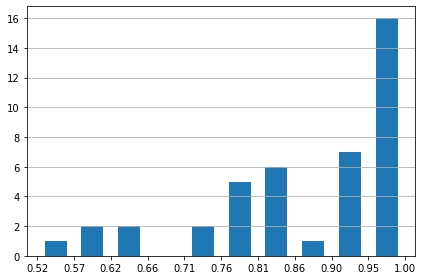

In [25]:
# plt.figure(figsize=(12,7))
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(sorted([float(x) for x in tp]), rwidth=.6)
ax.set_xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.2f'))
ax.grid(which='major', axis='y', zorder=-1.0)
fig.tight_layout()
plt.savefig('../../figures/histogram_tp_freq.jpg')
# tp_fs = sorted([float(x) for x in tp])
# plt.hist(tp_fs, bins=50)
# plt.yticks(np.arange(Counter(tp_fs).most_common()[-1][1], 
#                      Counter(tp_fs).most_common()[0][1], 2))

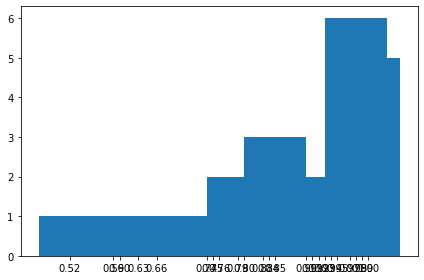

In [265]:
facecolor = '#EAEAEA'
color_bars = '#3475D0'
data = sorted([float(x) for x in tp])
labels, counts = np.unique(data, return_counts=True)
plt.bar(labels, counts, align='center', width=0.1)
plt.gca().set_xticks(labels)
plt.show()

In [259]:
counts

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 3, 1, 2, 1, 1, 2, 1, 1, 6, 4,
       5], dtype=int64)

In [60]:
fig = fig.get_figure()
fig.savefig('../../figures/prpo_correct_predictions_density.jpg')